In [1]:
import argparse
import os
import io
import random
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seed choice for deterministic results
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  4030


In [3]:
# Available Painter Supercategories
# sports, accessory, animal, outdoor, vehicle, person, indoor, appliance, electronic, furniture
# food, kitchen, water, ground, solid, sky, plant, structural, building, textile, window, floor
# ceiling, wall, rawmaterial
painter_type = "furniture"
image_size = 128
lo_bound = image_size // 4
up_bound = lo_bound + (image_size // 2)
sample_size = 2
train_path = 'inpainting/train2014'
dev_path = 'inpainting/val2014'
train_annotation_path='inpainting/annotations/instances_train2014.json'
dev_annotation_path='inpainting/annotations/instances_val2014.json'

In [4]:
with open(train_annotation_path, 'r') as R:
    train_ann = json.loads(R.read())
    
with open(dev_annotation_path, 'r') as V:
    valid_ann = json.loads(V.read())

cat_labels = ['']*91
for i in range(len(train_ann['categories'])):
    cat_labels[train_ann['categories'][i]['id']] = train_ann['categories'][i]['supercategory']

In [5]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path=train_path,
        dev_path=dev_path,
        train_annotation_path=train_annotation_path,
        dev_annotation_path=dev_annotation_path,
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    # JMAK - cropping to 128
    def _get_real_and_fake_images(self):            
        """Get real and fake images from path."""
        self.train_dataset = dset.CocoDetection(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.Compose([
                 transforms.CenterCrop(image_size),
                 transforms.ToTensor()])
        )
       
        self.valid_dataset = dset.CocoDetection(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.Compose([
                 transforms.CenterCrop(image_size),
                 transforms.ToTensor()])
        )
                
        # ELDRICK: First, copy over desired number of training and validation. 
        print('Populating training images & captions ...')
        train_images = []
        # There appears to be one image missing for some weird reason.
        try:
            for img, label in self.train_dataset:
                area_index = 0
                largest_area = 0
                try:
                    for j in range(len(label)):
                        if label[j]['area'] > largest_area:
                            largest_area = label[j]['area']
                            area_index = j
                    img_cat_id = label[area_index]['category_id']
                except:
                    pass
                if cat_labels[img_cat_id] == painter_type:
                    train_images.append(img)
                if len(train_images) % 500 == 0:
                    print("Gathered ", len(train_images), " training images so far")
                if len(train_images) == sample_size:
                    break
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        # ELDRICK: Second, changed this to match above to terminate
        print('Populating validation images ...')
        valid_images = []
        try:
            for img, label in self.valid_dataset:
                area_index = 0
                largest_area = 0
                try:
                    for j in range(len(label)):
                        if label[j]['area'] > largest_area:
                            largest_area = label[j]['area']
                            area_index = j
                    img_cat_id = label[area_index]['category_id']
                except:
                    pass
                if cat_labels[img_cat_id] == painter_type:
                    valid_images.append(img)
                if len(valid_images) % 500 == 0:
                    print("Gathered ", len(valid_images), " validation images so far")
                if len(valid_images) == sample_size:
                    break
        except IOError:
            pass
        
        valid_images = torch.stack(valid_images)

        # ELDRICK: Crop out 128 by 128
        # JMAK: Crop out 64x64 
        print('Cropping 64x64 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, lo_bound:up_bound, lo_bound:up_bound] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 64x64 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, lo_bound:up_bound, lo_bound:up_bound] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
                
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    # Return proper sized samples from minibatch - 128x128
    # return a 64 x 64 minibatch - JMAK
    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, lo_bound:up_bound, lo_bound:up_bound], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, lo_bound:up_bound, lo_bound:up_bound], fake_examples

In [6]:
iterator = DataIterator()
print("Number of Total Class Samples, Train: ", iterator.num_train)
print("Number of Total Class Samples, Valid: ", iterator.num_valid)

Processing data ...
loading annotations into memory...
Done (t=11.90s)
creating index...
index created!
loading annotations into memory...
Done (t=7.12s)
creating index...
index created!
Populating training images & captions ...
Populating validation images ...
Gathered  0  validation images so far
Gathered  0  validation images so far
Gathered  0  validation images so far
Gathered  0  validation images so far
Gathered  0  validation images so far
Cropping 64x64 patch for training images ...
Cropping 64x64 patch for validation images ...
Number of Total Class Samples, Train:  2
Number of Total Class Samples, Valid:  2


(-0.5, 127.5, 127.5, -0.5)

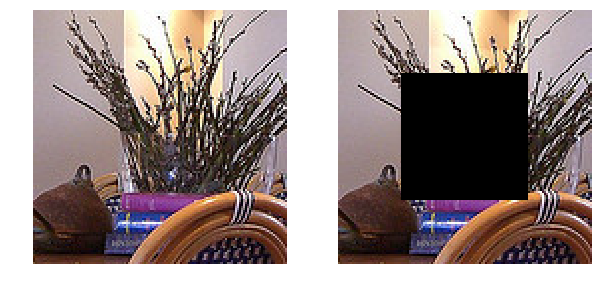

In [7]:
fig = plt.figure(figsize=(10, 5))
j = np.random.randint(low=0, high=iterator.num_train)
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[j].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[j].numpy().transpose(1, 2, 0))
plt.axis('off')

In [8]:
class Generator(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
        # input is (nc) x 128 x 128
        nn.Conv2d(3,start_filter,4,2,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef) x 64 x 64
        nn.Conv2d(start_filter,start_filter,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef) x 32 x 32
        nn.Conv2d(start_filter,start_filter*2,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*2),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*2) x 16 x 16
        nn.Conv2d(start_filter*2,start_filter*4,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*4),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*4) x 8 x 8
        nn.Conv2d(start_filter*4,start_filter*8,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*8),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*8) x 4 x 4
        nn.Conv2d(start_filter*8,4000,4, bias=False),
        
        # state size: (nBottleneck) x 1 x 1
        nn.BatchNorm2d(4000),
        nn.LeakyReLU(0.2, inplace=True),
        
        # input is Bottleneck, going into a convolution
        nn.ConvTranspose2d(4000, start_filter * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(start_filter * 8),
        nn.ReLU(True),
        
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(start_filter * 8, start_filter * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter * 4),
        nn.ReLU(True),
        
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(start_filter * 4, start_filter * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter * 2),
        nn.ReLU(True),
        
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(start_filter * 2, start_filter, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter),
        nn.ReLU(True),
        
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(start_filter, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. (nc) x 64 x 64
        )
    
    def forward(self, input):
        output = self.main(input)
        return output

In [9]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, start_filter, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(start_filter, start_filter * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(start_filter * 2, start_filter * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(start_filter * 4, start_filter * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(start_filter * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

In [ ]:
# Hyperparameters
learning_rate_gen = 1e-3
learning_rate_dis = 1e-3
betas_gen = (0.5, 0.999)
betas_dis = (0.5, 0.999)

generator = Generator(start_filter=64).cuda()
# discriminator = Discriminator(start_filter=64).cuda()
# optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate_gen, betas=betas_gen)
# optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate_dis, betas=betas_dis)
# clamp_lower = -0.03
# clamp_upper = 0.03
# loss_criterion = nn.MSELoss().cuda()
# save_dir = 'inpainting/samples'

In [ ]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    # ELDRICK: Change random to fit your sample size
    j = np.random.randint(low=0, high=iterator.num_valid)
    # ELDRICK: Change minibatch size to fit samples
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 64)
    generator.eval()
    reconstructions = generator(fake_images)
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, lo_bound:up_bound, lo_bound:up_bound] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'inpainting/samples/epoch_s%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()

In [ ]:
criterion = nn.BCELoss()
criterionMSE = nn.MSELoss()
for i in range(500):
    discriminator_losses = []
    generator_losses = []
    for j in range(0, iterator.num_train, 64):        
        ############################
        # (1) Update D network
        ############################
        for disc_updates in range(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 64)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            
            true_labels = torch.ones(D1.size()).cuda()
            fake_labels = torch.zeros(D2.size()).cuda()
            
            # Utilize BCE Loss
            real_d_loss = criterion(D1, true_labels).cuda()
            fake_d_loss = criterion(D2, fake_labels).cuda()
            
            discriminator_loss = real_d_loss + fake_d_loss
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward(retain_graph=True)
            
            optimizer_discriminator.step()
            discriminator_losses.append(discriminator_loss.item())

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        
        # Changing Gen Loss to utilize BCE + L2 MSE Loss
        gen_bce_loss = criterion(D2, true_labels).cuda()
        gen_l2_loss = criterionMSE(fake, real_examples).cuda()
        
        generator_loss = 0.001*gen_bce_loss + 0.999*gen_l2_loss
        
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.item())

    print('[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses)))
    save_plots(i, fake_images, real_examples, real_examples_full)

In [ ]:
state = {
    'generator_state': generator.state_dict(),
    'discriminator_state': discriminator.state_dict(),
}
torch.save(state, 'inpainting/painter_furniture_state_test')